### MNIST Neural Network
#### Sam Berkson
#### CPSC 323

For this project, I will train a neural network on the MNIST dataset to predict the value of handwritten numbers (0-9).  First, lets load our dataset and split it into training and testing.  We will then normalize our X set, and convert our Y set to categorical.

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import os

# Load, split, and normalize the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

input_shape = (28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.0

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

Now that our data is ready to work with, lets define our model.  I used a traditional convolutional neural network structure, modeled after our in class diagram (see below) and modified after some online research.  I initially just copied the diagram and ran it, but was getting >70% accuracy.  After some googling, I came across this article:
* https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial/notebook

Here I got the idea to double the Conv2D layers, and add the dropout layers.  The double Conv2D layers allow us to transform image fragments into 5x5 and then 3x3 matrices.  The MaxPool2D allows us to reduce a 2x2 matrix to a single pixel, maintaining the main feature integrity.  The Dropout layers ignore 25% of layers,  preventing us from overfitting.  This ended up working really well, as displayed in the results.  

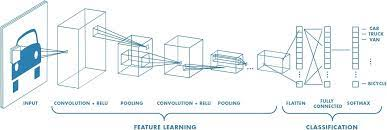

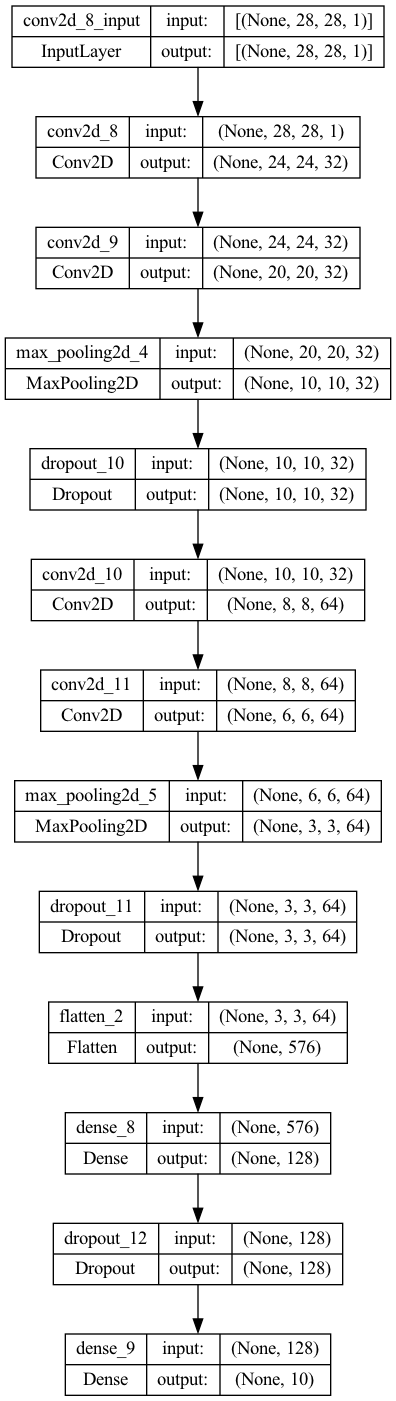

In [18]:
from keras.utils.vis_utils import plot_model

# Define and build the model (convolutional neural network, modeled after our in class example)
model = tf.keras.models.Sequential([
    # Convolutional network
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    # Fully connected feed-forward network )
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax') # Softmax for multi-class classification
])

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Now we need to build our checkpoint system so we can load our best epoch on every training iteration.  I got most of this code from Ben Lombardi's neural network, with some alterations to fit my model.

In [19]:
# Build epoch checkpoint callback
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 5,
        verbose = 1,
        min_delta = 0,
        mode = 'max',
        baseline = None,
        restore_best_weights = True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join("/Users/sberkson/Desktop/Gonzaga/JuniorYear/CPSC323-01/MNIST Neural Network 2: Electric Boogaloo", 'ckpt', "{epoch:02d}-{val_loss:.2f}.hdf5"),
        monitor = 'val_accuracy',
        verbose = 1,
        save_best_only = True,
        save_weights_only = False,
        mode = 'max',
        save_freq = 'epoch',
        options = None,
        initial_value_threshold = None
    )   
]

With our checkpoint system done, its time to compile and train our model.  I use a .1 split for my validation set, splitting off tof the training set.  I use categorical cross entropy to track my loss, and accuracy and mean squared error as my metrics.  I train over 10 epochs.

In [20]:
# Compile the model
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01, epsilon = 1e-08),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy', 'mse'])

# Train the model
history = model.fit(x_train, y_train, batch_size = 64, 
                                      epochs = 500, 
                                      validation_split = 0.4, 
                                      callbacks = callbacks)

Epoch 1/500
562/563 [============================>.] - ETA: 0s - loss: 1.2458 - accuracy: 0.5770 - mse: 0.0540
Epoch 1: val_accuracy improved from -inf to 0.90083, saving model to /Users/sberkson/Desktop/Gonzaga/JuniorYear/CPSC323-01/MNIST Neural Network 2: Electric Boogaloo/ckpt/01-0.33.hdf5
563/563 [==============================] - 40s 70ms/step - loss: 1.2452 - accuracy: 0.5772 - mse: 0.0540 - val_loss: 0.3343 - val_accuracy: 0.9008 - val_mse: 0.0155
Epoch 2/500
562/563 [============================>.] - ETA: 0s - loss: 0.4693 - accuracy: 0.8541 - mse: 0.0217
Epoch 2: val_accuracy improved from 0.90083 to 0.94458, saving model to /Users/sberkson/Desktop/Gonzaga/JuniorYear/CPSC323-01/MNIST Neural Network 2: Electric Boogaloo/ckpt/02-0.18.hdf5
563/563 [==============================] - 40s 72ms/step - loss: 0.4693 - accuracy: 0.8541 - mse: 0.0217 - val_loss: 0.1819 - val_accuracy: 0.9446 - val_mse: 0.0085
Epoch 3/500
562/563 [============================>.] - ETA: 0s - loss: 0.3000 -

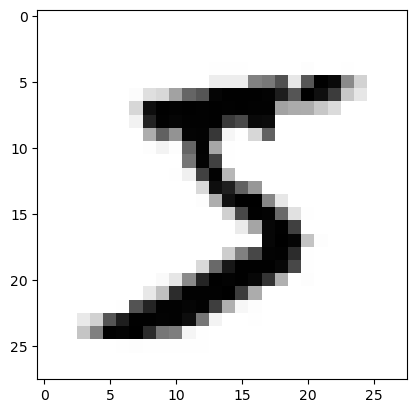

<Figure size 640x480 with 0 Axes>

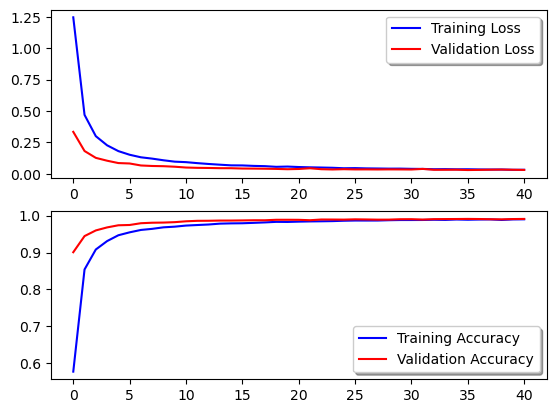

In [21]:
# Plot the model's training
plt.figure()
fig, ax = plt.subplots(2,1)
# 0 is loss, 1 is accuracy
ax[0].plot(history.history['loss'], 
           color = 'b', 
           label = "Training Loss")
ax[0].plot(history.history['val_loss'], 
           color = 'r', 
           label = "Validation Loss",
           axes = ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], 
           color = 'b', 
           label = "Training Accuracy")
ax[1].plot(history.history['val_accuracy'], 
           color = 'r',
           label = "Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

In [22]:
# Predict y values for the test set
y_pred = model.predict(x_test)
correct, incorrect = 0, 0 # Initialize counters
for index, prediction in enumerate(y_pred): # Iterate through the predictions
    true = np.argmax(y_test[index]) # Get the true value
    pred = np.argmax(prediction) # Get the predicted value
    if(pred == true): # If the prediction is correct
        correct += 1
    else: # If the prediction is incorrect
        incorrect += 1

print("Correct: ", correct)
print("Incorrect: ", incorrect)


313/313 [==============================] - 2s 5ms/step


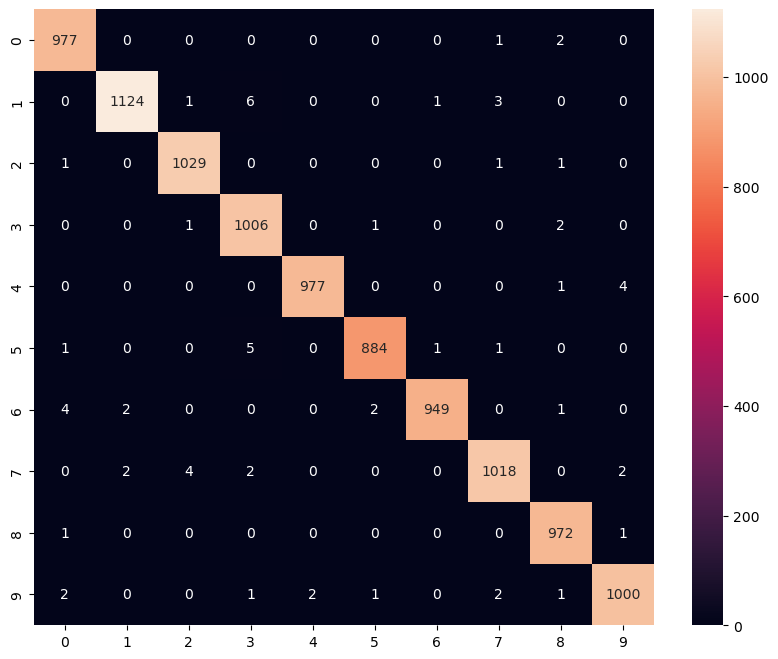

In [23]:
# Confusion matrix
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.show()

In [24]:
class Model:
    def __init__(self, model):
        self.model = model

    def predict(self, X_test):
        return model.predict(X_test)


313/313 [==============================] - 2s 5ms/step
Correct:  9936
Incorrect:  64


In [ ]:

Network = Model(model) # Create a model object
